# Fast Imaging Pulse Sequences

Modern MRI scanning relies heavily fast imaging pulse sequences, primarily echo-planar imaging (EPI) and multiple Spin-echo (RARE/FSE/TSE) methods.  These allow for multiple k-space lines to be acquired within a single TR.


## Learning Goals

1. Describe how images are formed
    * Describe how data is acquired in FSE/TSE sequences
    * Describe how EPI works
    * Understand what "spoiling" means
1. Understand the most popular pulse sequences and their acronyms
    * Describe how FSE/TSE sequences work
    * Describe how EPI works
    * Describe how fast gradient-echo sequences work
1. Manipulate MRI sequence parameters to improve performance
    * Understand how and when to accelerate with FSE/TSE
    * Understand how and when to accelerate with EPI
    * Understand how contrast changes in fast gradient-echo sequences
1. Identify artifacts and how to mitigate them
    * Identify FSE/TSE artifacts include T2 blurring
    * Identify EPI artifacts including distortion and T2*
    * Identify fast gradient-echo artifacts such as banding in bSSFP

## Multiple Spin-echo Sequences (RARE/FSE/TSE) 

These pulse sequences use multiple spin-echo refocusing pulses after a single exictation pulse to acquire multiple k-space lines to be acquired during the multiple spin-echoes that are formed.  This technique was originally called Rapid Acquisition with Relaxation Enhancement (RARE), and is known on various MRI scanners as fast spin-echo (FSE, GE Healthcare), turbo spin-echo (TSE, Siemens Healthineers), or turbo field-echo (TFE, Philips Healthcare).

This is the most common pulse sequence used in clinical practice.  This is because it is highly SNR efficient and can also be used to generate multiple contrasts.  They are particularly effective for T2 and PD-weighted imaging.

### Simplified Pulse Sequence Diagram

![Multiple spin-echo Pulse Sequence Diagram](images/pulse_sequence-diagram-fastspinecho-simple.png) 

### Sequence parameters

* Echo spacing ($t_{esp}$) - time between each spin-echo
* Echo train length (ETL) - number of spin-echoes with a repetition
* Effective TE ($TE_{eff}$) - the echo time when the data closest to the center of k-space is acquired.  

### Tradeoffs

Pros
* Fast
* SNR efficient
* Supports multiple contrasts by manipulating $TE_{eff}$

Cons
* Long echo train lengths can lead to T2 blurring or other distortions
* High SAR from repeated refocusing pulses

## Echo-planar Imaging (EPI)

These pulse sequences readout multiple k-space lines sequentially for faster imaging.  It is commonly used for diffusion-weighted imaging and fMRI.

### Pulse Sequence and K-space Diagram

![EPI Pulse Sequence](images/pulse_sequence-diagram-EPI.png)

### Sequence parameters

* Echo spacing ($t_{esp}$) - time between each readout and gradient-echo
* Echo train length (ETL) - number of readouts or k-space lines acquired within a repetition
* TE - the time when the data closest to the center of k-space is acquired.  

### Tradeoffs

Pros
* Extremely Fast, supporting single-shot imaging

Cons
* Susceptible to chemical shift and susceptibility displacement artifacts
* Sensitive to gradient fidelity artifacts (e.g. Nyquist ghosting)
* Long echo train lengths can lead to T2* blurring

## Fast gradient-echo sequences

The basic gradient-echo sequence is typically a spoiled gradient-echo sequence.  The sequence is called spoiled because the transverse magnetization is spoiled by a spoiler gradient before the next RF pulse.

### Spoiler or Crusher gradients

A large, unbalanced gradient will create dephasing of the transverse magnetization across the imaging voxels.  This effectively eliminates the signal.  However, the net magnetization is not truly eliminated, and this can be refocused by gradients.

### RF spoiling

The RF axis of rotation is changed every TR.  This reduces the chances of magnetization from previous TRs to become coherently excited.  Specific RF spoiling schemes, such as quadratic phase incrementation, is required for this to be effective.

### Types of fast gradient-echo sequences

Spoiled gradient-echo (SPGR)/fast low-angle shot (FLASH)
* Aims to full spoil transverse magnetization every TR
* Both gradient and RF spoiling are used
* Pure T1 weighted contrast

$$S_{SPGR} \propto M_0 \sin \theta \frac{1 - \exp(-TR/T_1)}{1 - \cos \theta \exp(-TR/T_1)}$$

Gradient-recalled acquisition in the steady state (GRASS)/fast imaging with steady-state precession (FISP)
* Allows for residual transverse magnetization to be used in the next TR
* Refouces frequency and phase encoding gradients
* RF spoiling used
* Increases T2* contrast


Steady-state free precession (SSFP)/time-reversed fast imaging with steady-state precession (PSIF)
* Use gradients to refocus signals from previous TRs
* Gradient spoiling but refocused in later TRs
* Creates T2/T1 contrast

Balanced SSFP/TrueFISP
* Balanced gradients every TR
* No spoiling, all magnetization preserved each TR
* Creates T2/T1 contrast
* High SNR efficiency

![bSSFP Pulse Sequence](images/pulse_sequence-diagram-bSSFP.png)

$$S_{bSSFP} \propto \frac{M_0}{2} \sqrt{\frac{T_2}{T_1}}$$


### Magnetization Prepared Fast Gradient-echo Sequences

Magnetization preparation schemes, such as inversion recovery, T2-preparation, and magnetization transfer, encode contrast in the longitudinal magnetization.  This contrast can be efficiently imaged with multiple gradient-echo readouts after a single magnetization preparation module.

The most common of this type of sequence is the Magnetization Prepared Rapid Gradient Echo (MPRAGE) sequence for brain imaging, which specifically uses inversion recovery magnetization preparation to create T1-weighted contrast, followed by multiple spoiled gradient-echo readouts to retain only T1-weighted contrast.

![Magnetization Prepared Fast Gradient-echo Pulse Sequence](images/pulse_sequence-diagram-mprage.png)

This sequence includes several additional parameters, including the recovery time, $T_{recovery}$, and number of readouts per preparation, $N_{segments}$, as well as the specific paramters of the magnetization preparation.

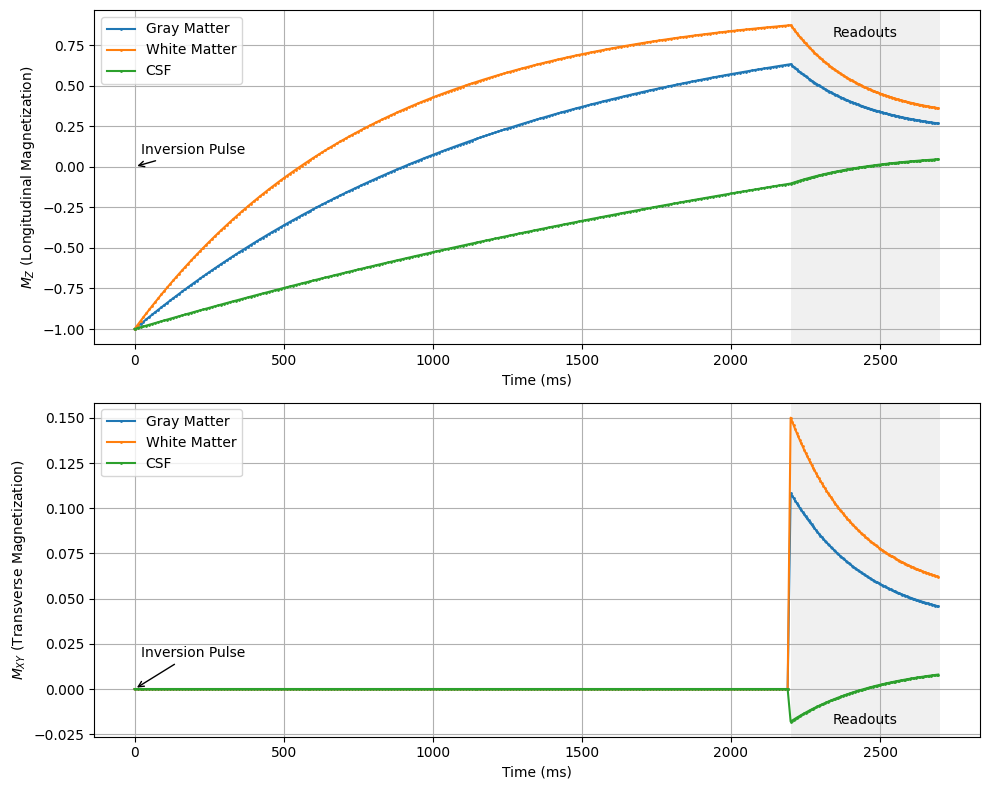

In [22]:
# Simulate MPRAGE MRI Pulse Sequence, which typically uses inversion preparation

import numpy as np
import matplotlib.pyplot as plt

flip_angle = 10 * np.pi / 180  # Flip angle in radians
TE = 1  # Echo time in ms
TR = 5 # Repetition time in ms
N_segments = 100  # Number of pulses
T_recovery = 2200  # Delay after inversion pulse in ms

MZ_start = 1.0  # Initial longitudinal magnetization
MZ_inversion = -MZ_start  # After inversion pulse

t_recovery = np.arange(0, T_recovery, 10)  # Time array for recovery period
t_segments = np.arange(0, N_segments * TR, TR) + T_recovery  # Time array for pulse sequence

# Define T1/T2 values for different tissue types
tissues = {
    'Gray Matter': {'T1': 1300, 'T2': 80},
    'White Matter': {'T1': 800, 'T2': 110},
    'CSF': {'T1': 3700, 'T2': 1700}
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for tissue_name, params in tissues.items():
    T1, T2 = params['T1'], params['T2']
    
    # Vectorized longitudinal recovery during the inversion recovery period
    MZ_recovery = MZ_inversion * np.exp(-t_recovery / T1) + (1 - np.exp(-t_recovery / T1))

    MZ_segments = np.zeros(N_segments)
    MXY_segments = np.zeros(N_segments)
    
    # Longitudinal magnetization at the start of the segmented readouts
    MZ_segments[0] = MZ_inversion * np.exp(-T_recovery / T1) + (1 - np.exp(-T_recovery / T1))
    for n in range(1, N_segments):
        MZ_segments[n] = MZ_segments[n-1] * np.cos(flip_angle) * np.exp(-TR / T1) + (1 - np.exp(-TR / T1))
    
    for n in range(0, N_segments):
        MXY_segments[n] = MZ_segments[n] * np.sin(flip_angle) * np.exp(-TE / T2)
    
    ax1.plot(np.concatenate((t_recovery, t_segments)), np.concatenate((MZ_recovery, MZ_segments)), label=tissue_name, marker='o', markersize=1)
    ax2.plot(np.concatenate((t_recovery, t_segments)), np.concatenate((np.zeros_like(MZ_recovery), MXY_segments)), label=tissue_name, marker='o', markersize=1)

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('$M_Z$ (Longitudinal Magnetization)')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('$M_{XY}$ (Transverse Magnetization)')
ax2.legend()
ax2.grid(True)

# Annotations
start_readouts = T_recovery
end_readouts = T_recovery + N_segments * TR
mid_readouts = (start_readouts + end_readouts) / 2

y1_min = ax1.get_ylim()[0]
y2_min = ax2.get_ylim()[0]
y1_max = ax1.get_ylim()[1]
y2_max = ax2.get_ylim()[1]

ax1.annotate('Inversion Pulse', xy=(0, 0), xytext=(20, y1_max * 0.15),
             arrowprops=dict(arrowstyle='->'), ha='left', va='top')
ax2.annotate('Inversion Pulse', xy=(0, 0), xytext=(20, y2_max * 0.15),
             arrowprops=dict(arrowstyle='->'), ha='left', va='top')

ax1.text(mid_readouts, y1_max * 0.9, 'Readouts', ha='center', va='top')
ax2.text(mid_readouts, y2_min * 0.5, 'Readouts', ha='center', va='top')
ax1.axvspan(start_readouts, end_readouts, color='0.9', alpha=0.6, linewidth=0)
ax2.axvspan(start_readouts, end_readouts, color='0.9', alpha=0.6, linewidth=0)

plt.tight_layout()
plt.show()
